本ノートブックでは、日本語データセットに対してBERTopicを用いてクラスタリングとトピック表現の抽出および可視化をします。

In [1]:
!pip install -q japanize-matplotlib bertopic sentence-transformers spacy[ja]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━

In [2]:
from pathlib import Path

import japanize_matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.ja import Japanese
from umap import UMAP

クラスタリングの対象とするデータセットをダウンロードしましょう。今回は、言語処理学会年次大会で発表された論文のタイトルを含むデータセットを利用します。事前に前処理済みで、英語のみのタイトルは除去してあります。

In [3]:
!wget https://gist.githubusercontent.com/Hironsan/e1c1c39348a700073717382bbfc07e20/raw/85bce46c1f9b8ff7fe13b890405df29f12f55cb3/japanese_nlp_papers.csv

--2025-06-12 08:29:35--  https://gist.githubusercontent.com/Hironsan/e1c1c39348a700073717382bbfc07e20/raw/85bce46c1f9b8ff7fe13b890405df29f12f55cb3/japanese_nlp_papers.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358413 (350K) [text/plain]
Saving to: ‘japanese_nlp_papers.csv’

japanese_nlp_papers 100%[===================>] 350.01K  --.-KB/s    in 0.007s  

2025-06-12 08:29:36 (51.8 MB/s) - ‘japanese_nlp_papers.csv’ saved [358413/358413]



データセットをダウンロードしたら中身を確認してみましょう。以下に示すように、論文の発行年とタイトルが格納されていることがわかります。

In [4]:
df = pd.read_csv("japanese_nlp_papers.csv")
df.head()

,year,title
0,2016,対話システムの理論と実践
1,2016,言語進化史の統計的研究
2,2016,音声・画像・映像処理における深層学習
3,2016,言語研究のための言語資源整備～凸最適化からの脱却～
4,2016,医療分野におけるビッグデータ活用の実態と課題


以下に、年別の論文数を可視化した結果を示します。ここ数年の急激な伸びが目立ちます。なお、この数字はフィルタリング後の論文数であることに注意してください。

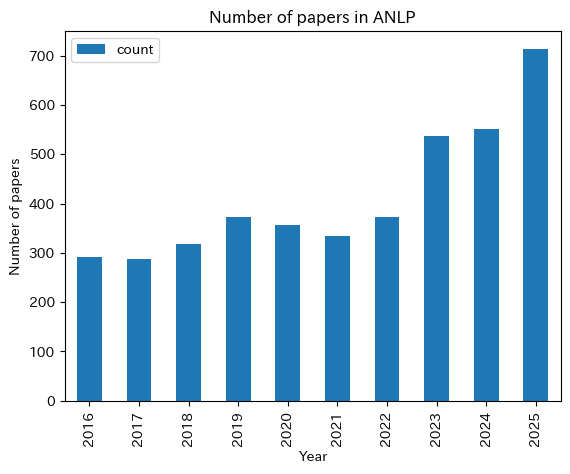

In [5]:
df_count = df.groupby("year").size().reset_index(name="count")
df_count.plot(x="year", y="count", kind="bar")
plt.title("Number of papers in ANLP")
plt.xlabel("Year")
plt.ylabel("Number of papers")
plt.show()

データセットを用意したら、埋め込みモデルを読み込みます。今回は、執筆時点では日本語タスクで最高レベルに性能の良い[ruri-v3-310m](https://huggingface.co/cl-nagoya/ruri-v3-310m)を使用します。

In [6]:
embedding_model = SentenceTransformer("cl-nagoya/ruri-v3-310m")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.78k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.72M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

モデルを用意できたら、論文のタイトルを渡しましょう。`ruri-v3-310m`はテキストにプレフィックスを付けることでタスクごとに適した埋め込みを生成する機能があります。今回は、クラスタリング向けのプレフィックスとして「トピック: 」を付けています。

In [7]:
titles = [f"トピック: {title}" for title in df["title"].values]
embeddings = embedding_model.encode(titles, show_progress_bar=True)

Batches:   0%|          | 0/130 [00:00<?, ?it/s]

埋め込みを次元削減するための準備をしましょう。

In [8]:
umap_model = UMAP(
    n_components=20,
    n_neighbors=5,
    min_dist=0.0,
    metric="cosine",
    random_state=42,
)

埋め込みを用いてクラスタリングする準備をします。書籍ではHDBSCANを使用していましたが、今回はKMeansを利用しています。KMeansはクラスタ数を渡す必要があることに注意してください。今回は、年次大会のセッションの分野をもとに決めています。

In [9]:
kmeans_model = KMeans(n_clusters=25, random_state=42)

トピック表現を得るための`CountVectorizer`を用意します。トークナイザーとしてはSudachiを利用し、ストップワードをリストをダウンロードして`CountVectorizer`に渡しています。

In [10]:
!wget https://github.com/WorksApplications/elasticsearch-sudachi/blob/develop/src/main/resources/com/worksap/nlp/lucene/sudachi/ja/stopwords.txt

--2025-06-12 08:30:22--  https://github.com/WorksApplications/elasticsearch-sudachi/blob/develop/src/main/resources/com/worksap/nlp/lucene/sudachi/ja/stopwords.txt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘stopwords.txt’

stopwords.txt           [ <=>                ] 182.14K  --.-KB/s    in 0.009s  

2025-06-12 08:30:22 (20.4 MB/s) - ‘stopwords.txt’ saved [186513]



In [24]:
nlp = Japanese()


def tokenize(text: str) -> list[str]:
    # 名詞と固有名詞だけ残す
    return [token.norm_ for token in nlp(text) if token.pos_ in {"NOUN", "PROPN"}]


def load_stopwords(filename: str) -> list[str]:
    with Path(filename).open(encoding="utf-8") as f:
        stopwords = [line.strip() for line in f if not line.startswith("#")]
        stopwords += [
            "用い", "よる", "おける", "る", "的", "向け", "による", "における", "』", "『", "化", "度", "-", ":", "～",
        ]
    return stopwords


stopwords = load_stopwords("stopwords.txt")
vectorizer_model = CountVectorizer(tokenizer=tokenize, stop_words=stopwords)

これまでに定義したモデルを用いて、BERTopicを実行します。

In [22]:
topic_model = BERTopic(
    language="japanese",
    umap_model=umap_model,
    hdbscan_model=kmeans_model,
    vectorizer_model=vectorizer_model,
)
topics, probs = topic_model.fit_transform(
    documents=df.title,
    embeddings=embeddings,
)

実行して得られたトピックを確認してみましょう。対話システムや大規模言語モデルを表すトピックがありそうなことがわかります。また、Representation列を見ると「対話システム」や「機械翻訳」といった専門用語が分割されていることがわかります。このような用語を分割したくない場合、形態素解析用の辞書に専門用語を登録しておくのも1つの手です。

In [23]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,0,384,0_対話_発話_応答_システム,"[対話, 発話, 応答, システム, 雑談, 会話, 生成, 話者, 指向, 評価]","[多様な話者との自動対話に基づく雑談システムの自動評価, 応答の生成・評価・選択による対話シ..."
1,1,348,1_翻訳_機械_ニューラル_対訳,"[翻訳, 機械, ニューラル, 対訳, 日英, 英日, 統計, NMT, 評価, 文]","[ニューラル機械翻訳のための言語知識に基づくマルチタスク事前学習, 文脈情報を考慮した日英ニ..."
2,2,333,2_語_コーパス_日本_意味,"[語, コーパス, 日本, 意味, アノテーション, 動詞, 構築, 変化, 日常, 付与]","[『日本語日常会話コーパス』に対する係り受け情報アノテーション, 『日本語日常会話コーパス』..."
3,3,232,3_抽出_固有_ウィキペディア_表現,"[抽出, 固有, ウィキペディア, 表現, 特許, エンティティー, トピック, グラフ, ...","[固有表現候補の用語情報を取得するLLMを用いた固有表現抽出, 複数データセットで情報を共有..."
4,4,223,4_LLM_言語_規模_大,"[LLM, 言語, 規模, 大, モデル, 日本, 語, バイアス, 推論, 評価]","[大規模言語モデルの文処理は人間らしいのか？, 大規模言語モデルにおける日本語ゼロ照応解析能..."
5,5,222,5_画像_キャプション_生成_視覚,"[画像, キャプション, 生成, 視覚, 広告, 言語, モデル, マルチモーダル, 脳, 物体]","[ニューラルキャプション生成モデルによる画像説明文の選択, 敵対的生成ネットワークを用いて抽..."
6,6,207,6_レビュー_抽出_テキスト_商品,"[レビュー, 抽出, テキスト, 商品, 推薦, 情報, 分析, 記事, 金融, 株価]","[レビューに対する分散表現を用いた評判分析, 教師有り学習モデルと大規模言語モデルを組み合わ..."
7,7,206,7_感情_ツイート_推定_意見,"[感情, ツイート, 推定, 意見, 投稿, Twitter, 絵, 分析, SNS, 検出]","[主観感情と客観感情の強度推定のための日本語データセット, Twitterユーザの属性別感情..."
8,8,198,8_文書_データ_要約_モデル,"[文書, データ, 要約, モデル, 分類, BERT, 検索, 手法, 拡張, 文]","[単語を共有する文書グラフを用いた文書分類, 単語と文書の関係によるグラフを用いた文書分類,..."
9,9,188,9_モデル_言語_学習_事前,"[モデル, 言語, 学習, 事前, 層, transformer, 規模, 大, 生成, 敵対]","[大規模言語モデルに対する語彙置換継続事前学習の有効性の検証, 大規模言語モデルの浅い層が人..."


時系列でのトピックの変化を可視化してみましょう。

In [27]:
topics_over_time = topic_model.topics_over_time(
    df.title,
    df.year,
    global_tuning=False,
    evolution_tuning=False,
)

In [28]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=5)